# Inspiration for my 3am coding sessions
https://youtu.be/1SB5lMyPmuk?si=7lrMy8keMWtSzojO
$$\partial_t u + u \partial_x u - \nu \partial_{xx} u = 0 $$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import torch
import torch.nn as nn
from collections import OrderedDict
from tqdm import tqdm

class BasicNeuralNetwork(nn.Module):
  def __init__(
      self,
      input_size,
      output_size,
      hidden_layer_size,
      depth,
      activation_layer = nn.Tanh
  ):
    super(BasicNeuralNetwork,self).__init__()
    layers = [('input',nn.Linear(input_size,hidden_layer_size))]
    layers.append(('input_activation',activation_layer()))
    for index in range(depth):
      layers.append(
        ('hidden%d' % index, nn.Linear(hidden_layer_size,hidden_layer_size))
      )
      layers.append(('activation_%d' % index, activation_layer()))
    layers.append(('output',nn.Linear(hidden_layer_size,output_size)))
    layersDict = OrderedDict(layers)
    self.layers = nn.Sequential(layersDict)
  def forward(self,x):
    output = self.layers(x)
    return output

# Building the Specific PINN

In [2]:
class BurgerPinn:
  def __init__(self):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.model = BasicNeuralNetwork(
      input_size=2,
      output_size=1,
      hidden_layer_size=10,
      depth=5,
      activation_layer=nn.Tanh
    ).to(device)
    self.delta_x = 0.1
    self.delta_time = 0.1
    x = torch.arange(-1,1+self.delta_x,self.delta_x)
    time = torch.arange(0,1+self.delta_time,self.delta_time)
    self.exact_model = torch.stack(torch.meshgrid(x,time)).reshape(2,-1).T
    boundary_condition_1 = torch.stack(torch.meshgrid(x[0],time)).reshape(2,-1).T
    boundary_condition_2 = torch.stack(torch.meshgrid(x[-1],time)).reshape(2,-1).T
    intial_time_condition = torch.stack(torch.meshgrid(x,time[0])).reshape(2,-1).T
    self.train_exact_model = torch.cat([
      boundary_condition_1,
      boundary_condition_2,
      intial_time_condition
    ])
    u_boundary_condition_1 = torch.zeros(len(boundary_condition_1))
    u_boundary_condition_2 = torch.zeros(len(boundary_condition_2))
    u_intial_condition = -torch.sin(np.pi*intial_time_condition[:,0])
    self.u_train_exact_model = torch.cat([
      u_boundary_condition_1,
      u_boundary_condition_2,
      u_intial_condition
    ])
    self.u_train_exact_model = self.u_train_exact_model.unsqueeze(1)
    self.exact_model = self.exact_model.to(device)
    self.train_exact_model = self.train_exact_model.to(device)
    self.u_train_exact_model = self.u_train_exact_model.to(device)
    self.exact_model.requires_grad = True
    self.criteria = nn.MSELoss()
    self.iteration = 1
    self.optimizer = torch.optim.LBFGS(
      params=self.model.parameters(),
      lr=1.0,
      max_iter=50000,
      max_eval=50000,
      history_size=50,
      tolerance_grad=1e-7,
      tolerance_change=1.0*np.finfo(float).eps,
      line_search_fn="strong_wolfe"
    )
    self.adam = torch.optim.Adam(self.model.parameters())
  def loss_function(self):
    self.adam.zero_grad()
    self.optimizer.zero_grad()
    u_prediction = self.model(self.train_exact_model)
    data_loss = self.criteria(u_prediction, self.u_train_exact_model)
    u = self.model(self.exact_model)

    first_derivative = torch.autograd.grad(
      inputs=self.exact_model, 
      outputs=u, 
      grad_outputs=torch.ones_like(u), 
      retain_graph=True, 
      create_graph=True
    )[0]
    u_t = first_derivative[:, 1]
    u_x = first_derivative[:, 0]
    u_xx = torch.autograd.grad(
      inputs=self.exact_model, 
      outputs=first_derivative, 
      grad_outputs=torch.ones_like(first_derivative), 
      retain_graph=True, 
      create_graph=True
    )[0][:, 0]
    nu = 0.01/np.pi 
    pde_loss = self.criteria(u_t + u.squeeze() * u_x, nu * u_xx)
    loss = pde_loss + data_loss
    loss.backward()
    if self.iteration % 1000 == 0: 
        print(f'Iteration Count: {self.iteration} Current error:{round(loss.item(),5)}')
    self.iteration += 1
    return loss
  def train(self):
    self.model.train()
    for i in tqdm(range(self.iteration),desc=f"Adam run {self.iteration}"):
      self.adam.step(self.loss_function)
    print('Begining the LBFGS')
    self.optimizer.step(self.loss_function)
  def eval(self):
      self.model.eval() 

# "Time to Bleed" -Ronnie Coleman

In [3]:
YouCanHasCheeseBorger = BurgerPinn()
YouCanHasCheeseBorger.train()

c:\Users\benja\OneDrive\Documents\GitHub\School24\airfoilopt\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Adam run 1: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


Begining the LBFGS
Iteration Count: 1000 Current error:0.01177
Iteration Count: 2000 Current error:0.00149
Iteration Count: 3000 Current error:0.00047
Iteration Count: 4000 Current error:0.00023
Iteration Count: 5000 Current error:0.00019


# Graphing the trained model

In [4]:
YouCanHasCheeseBorger.model.eval()
delta_x = 0.01
delta_time = 0.01
x = torch.arange(-1,1,delta_x)
time = torch.arange(0,1,delta_time)
exact_solution = torch.stack(torch.meshgrid(x,time)).reshape(2,-1).T
exact_solution = exact_solution.to(YouCanHasCheeseBorger.exact_model.device)
final_model = YouCanHasCheeseBorger.model
final_model.eval()
with torch.no_grad():
  u_predicted = final_model(exact_solution).reshape(len(x),len(time)).cpu().numpy()
print(u_predicted.shape)
sns.set_style("white")
plt.figure(figsize=(5,3),dpi=3000)
plt.title('Burger\'s 1D solution')
ax = sns.heatmap(u_predicted,cmap='jet',xticklabels='auto',yticklabels='auto')
ax.set(xlabel='Time',ylabel='x')

(200, 100)


[Text(0.5, 150.6666666666666, 'Time'), Text(1035.6666666666665, 0.5, 'x')]

,0
0,0.007362
1,0.070574
2,0.132755
3,0.194091
4,0.254103
...,...
95,-0.306662
96,-0.247388
97,-0.186899
98,-0.125365


,0
0,0.007362
1,0.006674
2,0.005989
3,0.005315
4,0.004657
...,...
95,-0.004098
96,-0.004194
97,-0.004290
98,-0.004386


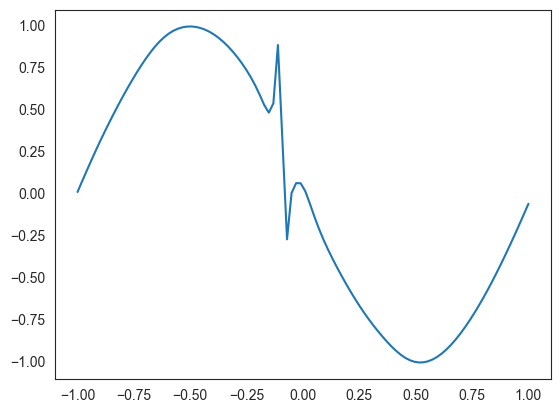

In [5]:
import pandas as pd
display(pd.DataFrame(u_predicted[::2,0]))
display(pd.DataFrame(u_predicted[0][:]))
plt.plot(np.linspace(-1,1,100),u_predicted[::2,0])
# specific_time_figure, (ax1,ax2,ax3) = plt.subplots(3,1)
# ax1.plot(u_predicted[0,:],u_predicted[::2,0])